In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.api as sms
from scipy import stats
import matplotlib.pyplot as plt
import plotly.express as px
import scipy
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import math
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import random
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import learning_curve


Bad key text.latex.preview in file C:\Users\spa84\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\spa84\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\spa84\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You proba

In [2]:
warnings.simplefilter('ignore')

In [25]:
df = pd.read_csv('./data/Before_Encoding_5000.csv', encoding='euc-kr')

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Building_Age                 5000 non-null   int64  
 1   JS_Price                     5000 non-null   int64  
 2   JS_BA                        5000 non-null   float64
 3   Population                   5000 non-null   int64  
 4   UR                           5000 non-null   float64
 5   LC_index                     5000 non-null   float64
 6   CA_index                     5000 non-null   float64
 7   TC_index                     5000 non-null   float64
 8   SDT_index                    5000 non-null   float64
 9   HSP_index                    5000 non-null   float64
 10  Sell_Price                   5000 non-null   float64
 11  Crime_Rates                  5000 non-null   float64
 12  IR                           5000 non-null   float64
 13  Region_Name       

## Categorical:

- Nominal(variables that have two or more categories, but which do not have an intrinsic order.)

    - Region_Name : 자치구 명
    - Building_Use : 건물 용도
    
- Ordinal(variables that have two or more categories just like nominal variables. Only the categories can also be ordered or ranked.)

    
## Numeric:

- Discrete
    - YearMonth : 년월
    - Building_Age : 건물연식
    - JS_Price : 전세가
   
- Continous
    - Sell_Price : 매매 가격
    - JS_BA = JS_Building Area : 임대 면적
    - lR = Interest Rate : 금리
    - UR = Unemployment Rate : 실업률
    - LC_index = Leading Composite index : 선행종합 지수
    - CA_index = Comprehensive Accompany index : 동행종합 지수
    - TC_index = Trailing Composite index : 후행종합 지수
    - SDT_index = Supply and Demand Trend index = 전세수급동향 지수
    - HSP_index = 
    - Population : 인구수
    - Crime_Rates : 범죄율
    - Shortest_Distance_to_Subway : 가장 가까운 지하철역과의 거리
    - Shortest_Distance_to_School : 가장 가까운 초중고등학교와의 거리
    - Shortest_Distance_to_Univ : 가장 가까운 대학교와의 거리
    - Shortest_Distance_to_Park : 가장 가까운 공원과의 거리
    

## 데이터 전처리

In [27]:
# 범주형 변수 리스트 지정
categorical_columns = ['Building_Use', 'Region_Name']
target_column = 'JS_Price'

# 데이터 분할
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# 학습 데이터에서 각 범주의 평균 타겟 값 계산
for categorical_column in categorical_columns:
    encoding_map = train_data.groupby(categorical_column)['JS_Price'].mean().to_dict()
    
    # 학습 데이터에 타겟 인코딩 적용
    train_data[categorical_column + '_encoded'] = train_data[categorical_column].map(encoding_map)
    
    # 기존 범주형 변수 삭제
    train_data.drop(columns=[categorical_column], inplace=True)

# 테스트 데이터에도 동일한 인코딩 매핑을 적용
for categorical_column in categorical_columns:
    test_data[categorical_column + '_encoded'] = test_data[categorical_column].map(encoding_map)
    
    # 기존 범주형 변수 삭제
    test_data.drop(columns=[categorical_column], inplace=True)

In [28]:
# JS_Price를 4개의 범주로 나눔
train_data['JS_Price_Category'] = pd.cut(train_data['JS_Price'], bins=5, labels=False)
test_data['JS_Price_Category'] = pd.cut(test_data['JS_Price'], bins=5, labels=False)

# 각 구간의 경계값을 구함
bin_edges = pd.cut(df['JS_Price'], bins=bins).unique()

# 결과 출력
print("구간의 경계값:")
print(bin_edges)

# 기존 변수 삭제
train_data.drop('JS_Price', axis=1, inplace=True)
test_data.drop('JS_Price', axis=1, inplace=True)

# 오버샘플링할 데이터와 레이블을 준비합니다.
X_train = train_data.drop('JS_Price_Category', axis=1)  # 독립변수
Y_train = train_data['JS_Price_Category']  # 종속변수
X_test = test_data.drop('JS_Price_Category', axis=1)  # 테스트 독립변수
Y_test = test_data['JS_Price_Category']  # 테스트 종속변수

# RandomOverSampler를 초기화합니다.
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# 오버샘플링을 적용합니다(테스트 데이터는 일반화 성능 평가를 위해 적용X)
X_train_resampled, Y_train_resampled = oversampler.fit_resample(X_train, Y_train)

# 오버샘플링된 데이터를 새로운 데이터프레임으로 만듭니다.
train_data_resampled = pd.concat([X_train_resampled, Y_train_resampled], axis=1)

각 클래스의 최솟값과 최댓값:
                      min     max
JS_Price_Category                
0                    1476   65000
1                   65700  125000
2                  130000  190000
3                  195000  250000
4                  305000  320000


## Logistic Regression Analysis

In [8]:
selected_features = ['CA_index',
'Shortest_Distance_to_School',
'HSP_index',
'TC_index',
'IR',
'SDT_index',
'UR']

In [9]:
# 독립 변수 선택
X_train_resampled = train_data_resampled[selected_features]

# 테스트 데이터에 대해 동일한 특성 선택 적용
X_test = X_test[selected_features]

# 데이터 표준화 (선택적)
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# 다항 로지스틱 회귀 모델 생성
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train_resampled, Y_train_resampled)

# 모델 평가 (정확도 계산)
accuracy = model.score(X_test, Y_test)
print(f"모델 정확도 : {accuracy}", '\n')

# 각 클래스에 속할 확률 예측
probabilities = model.predict_proba(X_test)

# 예측 결과 클래스 (가장 높은 확률을 갖는 클래스 선택)
predicted_classes = model.predict(X_test)

# 예측된 클래스 및 확률 출력
print("---예측된 클래스---", '\n', predicted_classes, '\n')
print("---클래스별 확률---", '\n', probabilities)

모델 정확도 : 0.552 

---예측된 클래스--- 
 [0 0 4 1 0 1 1 0 0 0 0 3 0 3 0 0 0 3 0 2 4 3 0 1 0 0 3 3 0 0 4 3 3 0 0 3 0
 0 3 0 4 3 0 4 3 3 3 4 0 0 0 3 0 0 3 0 0 0 3 0 0 0 0 0 0 1 0 0 0 4 0 0 0 3
 2 0 0 1 0 0 2 0 0 3 2 4 0 2 0 0 0 0 0 0 4 3 0 0 3 0 0 4 0 4 1 1 0 0 3 0 0
 4 0 3 3 0 0 3 0 3 0 0 3 0 0 1 0 0 3 0 0 0 0 3 3 0 1 0 4 3 1 0 3 0 0 0 0 3
 0 4 1 0 0 0 3 4 1 1 3 4 0 1 0 3 1 0 0 0 3 1 0 0 1 0 0 4 0 0 2 3 0 0 0 4 3
 3 1 2 0 0 0 0 1 0 1 4 0 1 2 0 0 0 3 4 0 3 4 0 0 3 4 3 0 0 0 3 2 3 3 0 0 0
 0 0 0 3 0 0 3 2 1 0 1 0 0 3 0 3 1 0 0 3 0 2 3 4 0 4 4 1 0 1 0 3 0 0 3 0 3
 3 1 0 0 0 4 3 1 3 0 0 1 0 3 1 0 0 0 4 0 3 4 4 0 0 0 0 0 4 0 4 0 3 0 0 0 3
 0 2 4 0 0 0 0 0 0 4 0 1 4 0 0 1 4 0 4 0 0 1 0 0 0 0 0 0 0 0 0 3 3 0 0 0 0
 0 0 0 0 0 4 3 0 3 0 0 0 0 0 0 3 0 3 1 4 3 0 1 1 0 1 0 0 3 0 0 3 1 0 0 3 0
 1 1 0 0 0 0 3 1 0 1 0 0 0 0 0 0 0 1 1 0 0 1 1 4 3 3 4 1 0 0 0 1 4 3 0 1 0
 0 0 2 1 0 0 3 0 0 3 4 0 0 3 4 4 0 3 3 3 0 0 2 0 0 1 1 2 0 0 0 0 3 3 0 2 0
 3 3 0 3 0 0 0 0 0 0 3 0 4 0 0 0 0 4 1 0 3 0 1 0 1 0 0 3 1 3 0 4 0 

## 교차검증
- data leakage 확인을 위해 교차검증 실행

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

# StratifiedKFold를 사용하여 k-폴드 교차 검증 설정
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 교차 검증 수행 및 결과 저장
cv_scores = []
for i, (train_idx, val_idx) in enumerate(kf.split(X_train_resampled, Y_train_resampled), 1):
    fold_X_train, fold_X_val = X_train_resampled[train_idx], X_train_resampled[val_idx]
    fold_Y_train, fold_Y_val = Y_train_resampled[train_idx], Y_train_resampled[val_idx]
    
    model.fit(fold_X_train, fold_Y_train)
    fold_Y_pred = model.predict(fold_X_val)
    
    fold_accuracy = model.score(fold_X_val, fold_Y_val)
    cv_scores.append(fold_accuracy)
    
    print(f"Fold {i} 정확도: {fold_accuracy}")
    print(f"Fold {i} 분류 보고서:\n{classification_report(fold_Y_val, fold_Y_pred)}")

# 교차 검증 결과 출력
print("교차 검증 정확도:", cv_scores)
print("평균 교차 검증 정확도:", sum(cv_scores) / len(cv_scores))

Fold 1 정확도: 0.3823121707790407
Fold 1 분류 보고서:
              precision    recall  f1-score   support

           0       0.57      0.61      0.59       722
           1       0.25      0.14      0.18       721
           2       0.28      0.07      0.11       722
           3       0.32      0.56      0.40       721
           4       0.40      0.53      0.46       721

    accuracy                           0.38      3607
   macro avg       0.36      0.38      0.35      3607
weighted avg       0.36      0.38      0.35      3607

Fold 2 정확도: 0.4006099251455503
Fold 2 분류 보고서:
              precision    recall  f1-score   support

           0       0.60      0.59      0.59       722
           1       0.28      0.16      0.21       721
           2       0.33      0.10      0.16       721
           3       0.34      0.66      0.45       722
           4       0.42      0.49      0.45       721

    accuracy                           0.40      3607
   macro avg       0.39      0.40      

## Training and validaion accuracy
- 학습곡선으로 데이터 크기 증가에 따른 훈련데이터와 검증 데이터의 정확도를 그림으로써 모델의 과적합을 시각적으로 확인

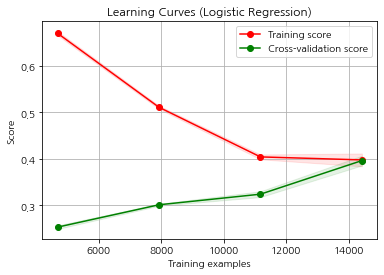

In [11]:
# 학습 곡선을 그리는 함수 정의
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# 학습 곡선 그리기
title = "Learning Curves (Logistic Regression)"
# 모델은 이미 훈련되었다고 가정합니다 (model 변수에 저장되어 있음)
plot_learning_curve(model, title, X_train_resampled, Y_train_resampled, cv=5, n_jobs=1)

plt.show()

## 변수선택법
- 모델의 복잡성이 줄어든 상태에서 통계적 유의성을 고려하여 변수선택을 위해 다중공선성과 p-value 체크

### 다중공선성

In [12]:
# X_train_resampled을 DataFrame으로 변환
X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=selected_features)

# 각 독립 변수의 VIF 계산
vif = pd.DataFrame()
vif["Features"] = X_train_resampled_df.columns
vif["VIF"] = [round(variance_inflation_factor(X_train_resampled_df.values, i), 0) for i in range(X_train_resampled_df.shape[1])]

print("독립 변수별 VIF:")
print(vif)

독립 변수별 VIF:
                      Features    VIF
0                     CA_index  102.0
1  Shortest_Distance_to_School    1.0
2                    HSP_index    9.0
3                     TC_index  118.0
4                           IR    5.0
5                    SDT_index    4.0
6                           UR    1.0


- VIF값 5를 기준으로 높으면 변수에서 제거할 요인으로 본다면 HSP_index, CA_index, TC_index를 제외한다.

### p-value

In [13]:
# 독립 변수를 데이터프레임으로 변환
X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=selected_features)

# 다항 로지스틱 회귀 모델 생성 (상수항 추가)
X_train_resampled_df = sm.add_constant(X_train_resampled_df)
model = sm.MNLogit(Y_train_resampled, X_train_resampled_df)

# 모델 피팅
result = model.fit()

# 독립 변수들의 p-value 추출
p_values = result.pvalues

# 결과 출력
print("P-values for independent variables:")
print(p_values)

Optimization terminated successfully.
         Current function value: 1.344762
         Iterations 8
P-values for independent variables:
                                        0             1              2  \
const                        1.751492e-40  6.051743e-42   5.210171e-01   
CA_index                     7.105189e-03  1.846877e-04   4.958019e-43   
Shortest_Distance_to_School  1.665322e-53  4.463683e-84  1.099439e-100   
HSP_index                    3.442084e-01  9.100571e-30   1.123095e-04   
TC_index                     1.378193e-07  6.044611e-02   1.252231e-08   
IR                           4.370782e-11  5.293402e-01   4.237696e-03   
SDT_index                    1.903892e-01  2.346884e-01   6.865389e-01   
UR                           3.298071e-02  1.529284e-14   3.699376e-05   

                                         3  
const                         6.338210e-28  
CA_index                      6.813279e-79  
Shortest_Distance_to_School  8.372018e-154  
HSP_index      

- a=0.1일 때, p-value값을 고려하면 IR, SDT_index, HSP_index을 제외한다.

## 최종결론
- Features_Ranking의 17가지 변수 중 상위 10가지를 제외한 7가지 변수에 대해 VIF와 Logistic Regression Analysis를 진행한다.
    - VIF와 Logistit Regression의 p-value값의 공통 제거요인인 HSP_index
    - VIF가 지나치게 높은 CA_index, Features_Ranking에서 최하위에 속하는 UR
    - 위의 세가지 요인(HSP_index, CA_index, UR)을 변수에서 제거하여 머신러닝을 진행한다.